In [261]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from dotenv import load_dotenv
import os

In [262]:
load_dotenv()

True

In [263]:
API_KEY = os.getenv('api_key')
ticker = "GSPC.INDX"

url = f"https://eodhd.com/api/eod/{ticker}"


params = {
    "from": "2017-01-01",
    "period": "d",
    "fmt": "json",
    "api_token": API_KEY
}

response = requests.get(url, params=params)
response.raise_for_status()

data = response.json()
data = pd.DataFrame(data)

data["date"] = pd.to_datetime(data["date"])

In [264]:
data.head()
data.to_csv(r'../data/raw/SP500.csv')
data.head()


,date,open,high,low,close,adjusted_close,volume
0,2017-01-03,2251.5701,2263.8799,2245.1299,2257.8301,2257.8301,3773010000
1,2017-01-04,2261.6001,2272.8201,2261.6001,2270.7500,2270.7500,3768890000
2,2017-01-05,2268.1799,2271.5000,2260.4500,2269.0000,2269.0000,3785080000
3,2017-01-06,2271.1399,2282.1001,2264.0601,2276.9800,2276.9800,3342080000
4,2017-01-09,2273.5901,2275.4900,2268.8999,2268.8999,2268.8999,3219730000


In [265]:
data = data.rename(columns={'close': 'Price'})
prices_sp500 = data[['date','Price']].copy()
prices_sp500 = prices_sp500.set_index("date")
print(prices_sp500.head())

                Price
date                 
2017-01-03  2257.8301
2017-01-04  2270.7500
2017-01-05  2269.0000
2017-01-06  2276.9800
2017-01-09  2268.8999


In [266]:
prices_sp500['Return'] = np.log(prices_sp500['Price'] / prices_sp500['Price'].shift(1))
prices_sp500.to_csv("../data/processed/sp500_returns.csv")
print(prices_sp500.head())
prices_sp500 = prices_sp500.dropna()
prices_sp500.describe()

                Price    Return
date                           
2017-01-03  2257.8301       NaN
2017-01-04  2270.7500  0.005706
2017-01-05  2269.0000 -0.000771
2017-01-06  2276.9800  0.003511
2017-01-09  2268.8999 -0.003555


,Price,Return
count,2298.000000,2298.000000
mean,4005.443922,0.000489
std,1273.455077,0.011702
min,2237.399900,-0.127652
25%,2852.757500,-0.003763
50%,3927.145000,0.000819
75%,4688.189925,0.005883
max,6978.600100,0.090895


<function matplotlib.pyplot.show(close=None, block=None)>

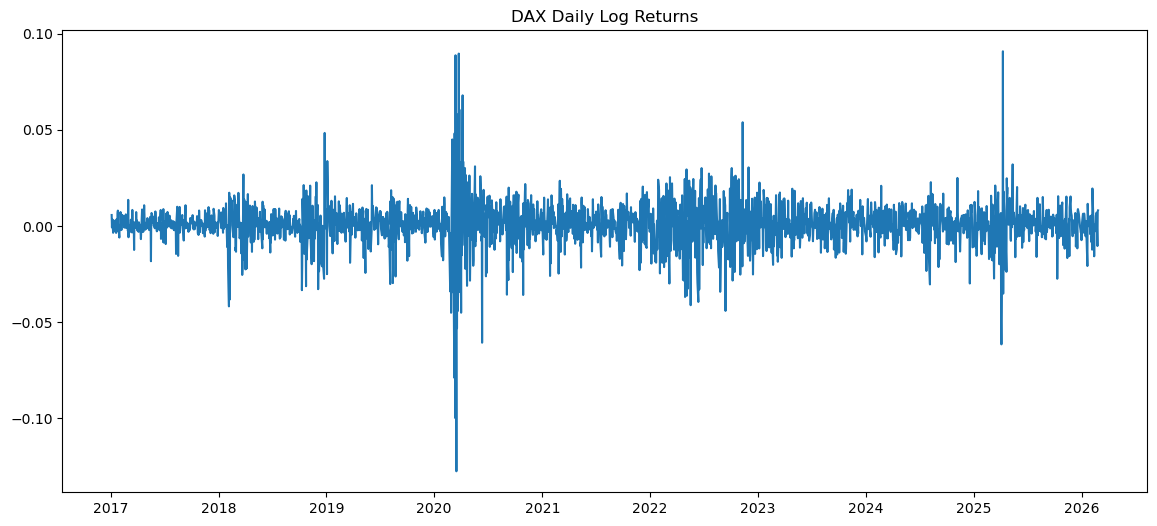

In [267]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(prices_sp500['Return'])
plt.title("DAX Daily Log Returns")
plt.show

In [268]:
y = prices_sp500['Return']
X = prices_sp500[['Return']].shift(1)
lags = []
for lag in lags:
    X[f"Return_lag{lag}"] = X["Return"].shift(lag)

X = X.dropna()
print(X.head())
print(y.head())

              Return
date                
2017-01-05  0.005706
2017-01-06 -0.000771
2017-01-09  0.003511
2017-01-10 -0.003555
2017-01-11  0.000000
date
2017-01-04    0.005706
2017-01-05   -0.000771
2017-01-06    0.003511
2017-01-09   -0.003555
2017-01-10    0.000000
Name: Return, dtype: float64


In [269]:
#Adding Volatility Feature
#Shift by 1, so Return at t is not included in the Vol calculation at Time t
prices_sp500['Vol_30'] = prices_sp500['Return'].rolling(20).std().shift(1)
prices_sp500 = prices_sp500.dropna()

#Add Volatility to Training Data
X['Vol_30'] = prices_sp500['Vol_30']
X = X.dropna()
y = y.reindex(X.index)

X.head()


,Return,Vol_30
date,,
2017-02-02,0.000298,0.003687
2017-02-03,0.000570,0.003477
2017-02-06,0.007238,0.003803
2017-02-07,-0.002118,0.003786
2017-02-08,0.000227,0.003674


In [270]:
from ngboost import NGBoost
from ngboost.distns import T
from ngboost.scores import LogScore
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler


In [271]:
print(X.shape)
print(y.shape)


print(y.isna().sum())

(2278, 2)
(2278,)
0


In [272]:
def run_expanding_backtest_ngboost(X, y, start_test_idx, var_levels, es_mc_samples):
    model = NGBoost(
        Dist=T,
        Score=LogScore,
        Base=DecisionTreeRegressor(max_depth=2, min_samples_leaf=50),
        learning_rate=0.01,
        n_estimators=200,
        natural_gradient=False,
        verbose=True,
    )
    rows = []
    
    X_vals = X.values
    y_vals = y.values
    idx = X.index
    n = len(X_vals)
    
    for t in range(start_test_idx, n):
        # Expanding window: train on everything up to t-1
        window = 756   
        start = max(0, t - window)
        X_train = X.iloc[start:t].values
        y_train = y.iloc[start:t].values    
        
        X_test = X_vals[t:t+1]  # ngboost needs 2d array - t:t+1
        y_test = float(y_vals[t])
        
        # Standardize X to improve numerical stability
        scaler_X = StandardScaler()
        X_train_std = scaler_X.fit_transform(X_train)
        X_test_std = scaler_X.transform(X_test)
        
        
        # Standardize y to stabilize StudentT fitting
        scaler_y = StandardScaler()
        y_train_std = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()
        
        model.fit(X_train_std, y_train_std)
        dist = model.pred_dist(X_test_std)
                
        out = {"Date": idx[t], "y_real": y_test}
        
        for a in var_levels:
            # Left tail probability
            q = 1 - a
            var_z = float(np.asarray(dist.ppf(q)).reshape(-1)[0])
            
            samples_z = dist.sample(es_mc_samples).reshape(-1)
            es_z = np.asarray(np.mean(samples_z[samples_z <= var_z]))
            
            var_val = float(scaler_y.inverse_transform([[var_z]])[0, 0])
            es_val  = float(scaler_y.inverse_transform([[es_z]])[0, 0])
            
            out[f"VaR_{int(a*100)}"] = var_val
            out[f"ES_{int(a*100)}"] = es_val
            
        rows.append(out)
    
    return pd.DataFrame(rows).set_index("Date")

In [273]:
start_test_idx = 252 * 3

res = run_expanding_backtest_ngboost(
    X,
    y,
    start_test_idx=start_test_idx,
    var_levels=[0.95, 0.99],
    es_mc_samples=3000
)

[iter 0] loss=1.2881 val_loss=0.0000 scale=1.0000 norm=1.6241
[iter 100] loss=1.1807 val_loss=0.0000 scale=0.5000 norm=0.8242
[iter 0] loss=1.2893 val_loss=0.0000 scale=1.0000 norm=1.6219
[iter 100] loss=1.1824 val_loss=0.0000 scale=1.0000 norm=1.6469
[iter 0] loss=1.2887 val_loss=0.0000 scale=1.0000 norm=1.6230
[iter 100] loss=1.1814 val_loss=0.0000 scale=1.0000 norm=1.6475
[iter 0] loss=1.2893 val_loss=0.0000 scale=1.0000 norm=1.6218
[iter 100] loss=1.1825 val_loss=0.0000 scale=0.5000 norm=0.8233
[iter 0] loss=1.2900 val_loss=0.0000 scale=1.0000 norm=1.6205
[iter 100] loss=1.1834 val_loss=0.0000 scale=1.0000 norm=1.6446
[iter 0] loss=1.2900 val_loss=0.0000 scale=1.0000 norm=1.6206
[iter 100] loss=1.1835 val_loss=0.0000 scale=1.0000 norm=1.6452
[iter 0] loss=1.2901 val_loss=0.0000 scale=1.0000 norm=1.6202
[iter 100] loss=1.1832 val_loss=0.0000 scale=1.0000 norm=1.6449
[iter 0] loss=1.2902 val_loss=0.0000 scale=1.0000 norm=1.6201
[iter 100] loss=1.1837 val_loss=0.0000 scale=1.0000 norm

In [274]:
res.to_csv("../data/processed/baseline_results.csv")
res.head()

,y_real,VaR_95,ES_95,VaR_99,ES_99
Date,,,,,
2020-02-05,0.011188,-0.009600,-0.015777,-0.019091,-0.029042
2020-02-06,0.003320,-0.010575,-0.016721,-0.020368,-0.030271
2020-02-07,-0.005415,-0.008959,-0.014909,-0.018896,-0.031377
2020-02-10,0.007300,-0.012400,-0.021443,-0.025072,-0.040944
2020-02-11,0.001687,-0.010094,-0.016351,-0.019943,-0.029082


In [275]:
viol_99 = (res["y_real"] < res["VaR_99"]).mean()
print("Observed violation rate 99%:", viol_99)

Observed violation rate 99%: 0.010512483574244415


In [276]:
res["violation_95"] = (res["y_real"] < res["VaR_95"]).astype(int)
res["violation_99"] = (res["y_real"] < res["VaR_99"]).astype(int)

violation_rate_95 = res["violation_95"].mean()
violation_rate_99 = res["violation_99"].mean()

print("Violation rate 95:", violation_rate_95)
print("Violation rate 99:", violation_rate_99)

Violation rate 95: 0.06636005256241786
Violation rate 99: 0.010512483574244415


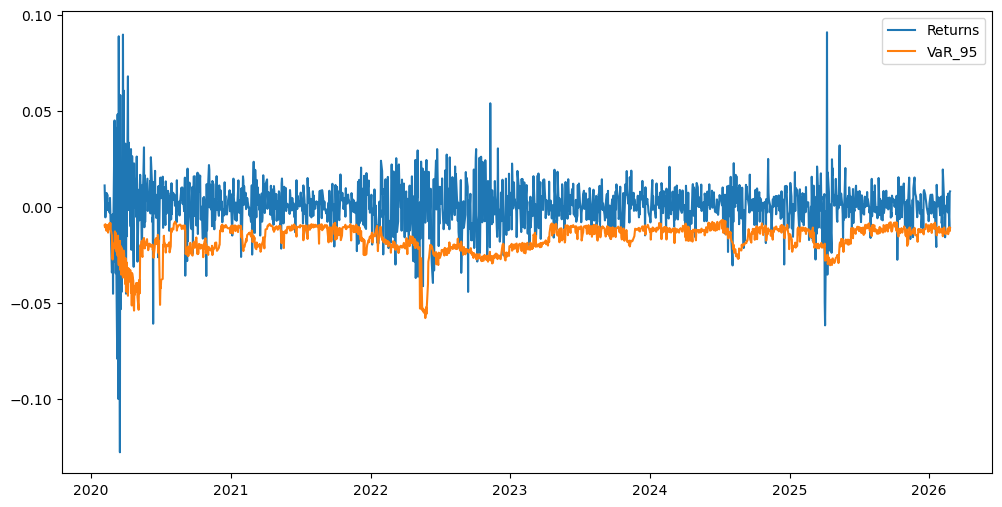

In [277]:
plt.figure(figsize=(12,6))
plt.plot(res.index, res["y_real"], label="Returns")
plt.plot(res.index, res["VaR_95"], label="VaR_95")
plt.legend()
plt.show()

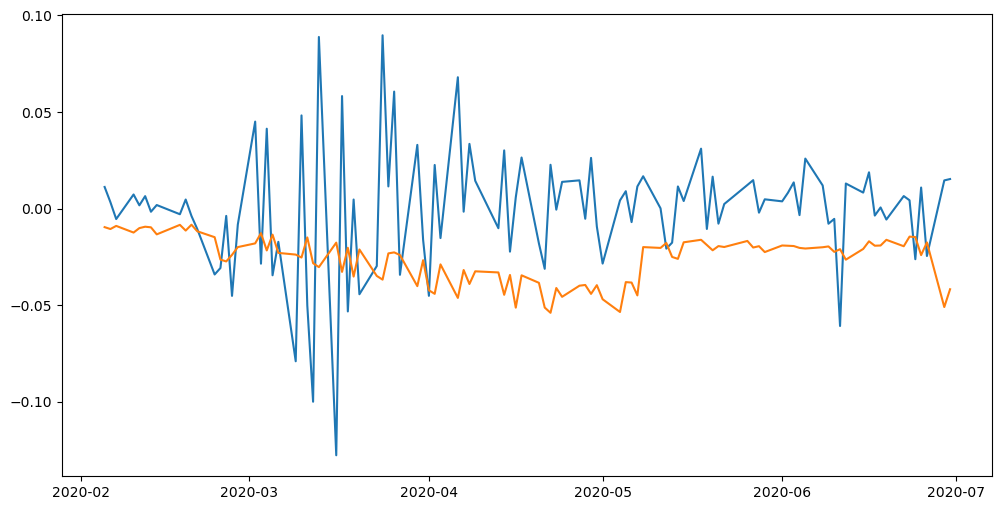

In [278]:
res_2020 = res[(res.index >= "2020-01-01") & 
               (res.index <= "2020-06-30")]

plt.figure(figsize=(12,6))
plt.plot(res_2020.index, res_2020["y_real"])
plt.plot(res_2020.index, res_2020["VaR_95"])

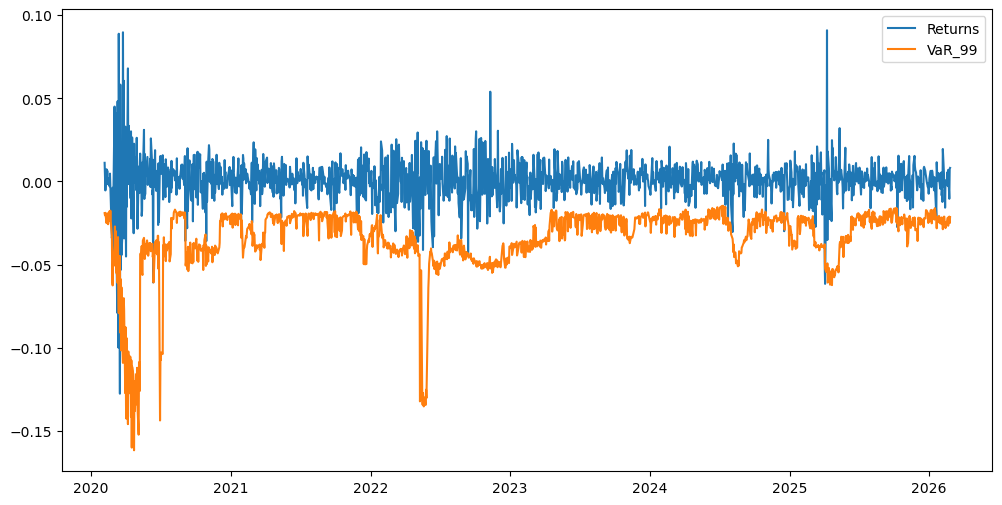

In [279]:
plt.figure(figsize=(12,6))
plt.plot(res.index, res["y_real"], label="Returns")
plt.plot(res.index, res["VaR_99"], label="VaR_99")
plt.legend()
plt.show()


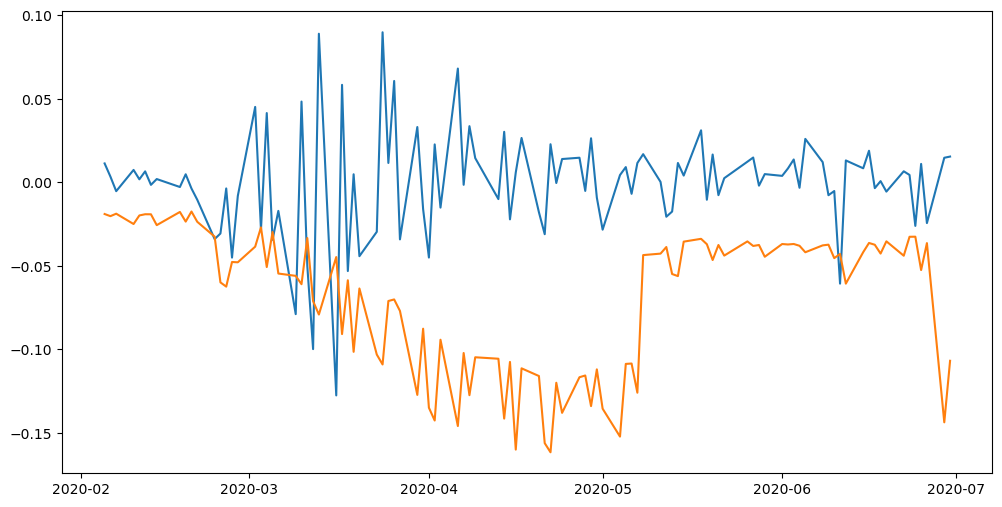

In [280]:
res_2020 = res[(res.index >= "2020-01-01") & 
               (res.index <= "2020-06-30")]

plt.figure(figsize=(12,6))
plt.plot(res_2020.index, res_2020["y_real"])
plt.plot(res_2020.index, res_2020['VaR_99'])

Violation rate 95: 0.07672131147540984
Violation rate 99: 0.019672131147540985 128



Violation rate 95: 0.07667103538663171 - 384 days, 0,005, 400, lags -1,2,5
Violation rate 99: 0.015727391874180863


Violation rate 95: 0.0727391874180865
Violation rate 99: 0.01310615989515072 - no lags 384


Violation rate 95: 0.0727391874180865
Violation rate 99: 0.011795543905635648 - 3 years

Violation rate 95: 0.06815114709851552
Violation rate 99: 0.006747638326585695 -60